In [1]:
from sqlalchemy import create_engine, inspect
import pandas as pd
import numpy as np
from dbgym.util.sql import substitute
from dbgym.spaces.observations.qppnet.features import QPPNetFeatures

import matplotlib.pyplot as plt
from models.qppnet import QPPNet
from math import ceil
from pathlib import Path
import re
import pickle

In [2]:
!ls artifact/experiment/tdtd

OnlyTest   PerfectPrediction	      tdtd_test.db
OnlyTrain  tdtd_PerfectPrediction.db  tdtd_train.db


In [3]:
# artifact_folder = Path("./artifact_tpch")
# train_name = "train"
# test_name = "test"
# experiment_name = "default"
# train_experiment_variation = "OnlyTrain"
# test_experiment_variation = "OnlyTest"

artifact_folder = Path("./artifact_dsb_batching")
train_name = "workload_train"
test_name = "workload_test"
experiment_name = "tgtd"
train_experiment_variation = "PerfectPrediction"
test_experiment_variation = "OnlyTest"

scalers_path = artifact_folder/ "experiment" / experiment_name / train_experiment_variation / "scalers.pkl"
with open(scalers_path, "rb") as f:
    scalers = pickle.load(f)
test_df_path = artifact_folder/ "experiment" / experiment_name / test_experiment_variation / "observations_0.parquet"
test_df = pd.read_parquet(test_df_path)
test_df["Query Hash"] = test_df["Query Hash"].apply(tuple)
display("Loading test dataframe to evaluate models with:")
display(test_df)

'Loading test dataframe to evaluate models with:'

,Children Observation Indexes,Features,Node Type,Observation Index,Query Hash,Query Num,Actual Total Time (us)
0,[1.0],"[172.0, 1.0, 8444.96, 0.0, 1.0, 0.0, 0.0, 0.0,...",Aggregate,0,"(0, 10, 0, 26, 26, 26, 17, 26, 31, 17, 16, 16)",2,92896.003723
1,[2.0],"[172.0, 2.0, 8444.91]",Gather,1,"(0, 10, 0, 26, 26, 26, 17, 26, 31, 17, 16, 16)",2,92885.002136
2,[3.0],"[172.0, 1.0, 7444.71, 0.0, 1.0, 0.0, 0.0, 0.0,...",Aggregate,2,"(0, 10, 0, 26, 26, 26, 17, 26, 31, 17, 16, 16)",2,38951.999664
3,"[4.0, 11.0]","[56.0, 1.0, 7444.68]",Nested Loop,3,"(0, 10, 0, 26, 26, 26, 17, 26, 31, 17, 16, 16)",2,38944.000244
4,"[5.0, 10.0]","[60.0, 94.0, 7401.17]",Nested Loop,4,"(0, 10, 0, 26, 26, 26, 17, 26, 31, 17, 16, 16)",2,33536.998749
...,...,...,...,...,...,...,...
12099,[],"[41.0, 48.0, 35.78, 0.0, 0.0, 0.0, 0.0, 1.0, 0...",Index Scan,12099,"(0, 26, 26, 10, 26, 26, 26, 17, 16, 16, 16, 16...",1820,182.999998
12100,[],"[21.0, 1.0, 0.32, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",Index Scan,12100,"(0, 26, 26, 10, 26, 26, 26, 17, 16, 16, 16, 16...",1820,1.000000
12101,[],"[12.0, 1.0, 0.34, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",Index Scan,12101,"(0, 26, 26, 10, 26, 26, 26, 17, 16, 16, 16, 16...",1820,3.000000
12102,[],"[8.0, 1.0, 0.74, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Index Scan,12102,"(0, 26, 26, 10, 26, 26, 26, 17, 16, 16, 16, 16...",1820,5.000000


In [4]:
normalized_df, scalers = QPPNetFeatures.normalize_observations_df(test_df, scalers=scalers)
display(normalized_df)

,Children Observation Indexes,Features,Node Type,Observation Index,Query Hash,Query Num,Actual Total Time (us),Actual Total Time (scaled)
0,[1.0],"[0.23529411852359772, 0.0, 0.2253580391407013,...",Aggregate,0,"(0, 10, 0, 26, 26, 26, 17, 26, 31, 17, 16, 16)",2,92896.003723,0.179564
1,[2.0],"[0.31111112236976624, 0.0006422607693821192, 0...",Gather,1,"(0, 10, 0, 26, 26, 26, 17, 26, 31, 17, 16, 16)",2,92885.002136,0.179543
2,[3.0],"[0.23529411852359772, 0.0, 0.19717997312545776...",Aggregate,2,"(0, 10, 0, 26, 26, 26, 17, 26, 31, 17, 16, 16)",2,38951.999664,0.075293
3,"[4.0, 11.0]","[0.08115942031145096, 0.0, 0.3776782751083374]",Nested Loop,3,"(0, 10, 0, 26, 26, 26, 17, 26, 31, 17, 16, 16)",2,38944.000244,0.075277
4,"[5.0, 10.0]","[0.08695652335882187, 0.011613385751843452, 0....",Nested Loop,4,"(0, 10, 0, 26, 26, 26, 17, 26, 31, 17, 16, 16)",2,33536.998749,0.064826
...,...,...,...,...,...,...,...,...
12099,[],"[0.09158416092395782, 0.012624227441847324, 0....",Index Scan,12099,"(0, 26, 26, 10, 26, 26, 26, 17, 16, 16, 16, 16...",1820,182.999998,0.000354
12100,[],"[0.04207920655608177, 0.0, 3.092578845098615e-...",Index Scan,12100,"(0, 26, 26, 10, 26, 26, 26, 17, 16, 16, 16, 16...",1820,1.000000,0.000002
12101,[],"[0.019801978021860123, 0.0, 3.456411650404334e...",Index Scan,12101,"(0, 26, 26, 10, 26, 26, 26, 17, 16, 16, 16, 16...",1820,3.000000,0.000006
12102,[],"[0.009900989942252636, 0.0, 0.0001073306775651...",Index Scan,12102,"(0, 26, 26, 10, 26, 26, 26, 17, 16, 16, 16, 16...",1820,5.000000,0.000010


In [5]:
display("Augmenting test dataframe with corresponding SQL queries:")

cand_train = artifact_folder / "experiment" / experiment_name / f"{experiment_name}_train.db"
cand_test = artifact_folder / "experiment" / experiment_name / f"{experiment_name}_test.db"
cand_transform = artifact_folder / "experiment" / experiment_name / f"{experiment_name}_{test_experiment_variation}.db"

obs_db = None
if test_experiment_variation == "OnlyTrain":
    obs_db = cand_train
elif test_experiment_variation == "OnlyTest":
    obs_db = cand_test
else:
    obs_db = cand_transformed

print(obs_db)
engine = create_engine(f"sqlite:///{obs_db}")
workload_df = pd.read_sql(f"SELECT w.query_num, qt.template, w.template_id, w.params_id FROM workload w, query_template qt WHERE w.template_id = qt.id", engine)
workload_df["query_num"] = workload_df["query_num"].astype(int)
workload_df["template"] = workload_df["template"].astype("category")
workload_df["template_id"] = workload_df["template_id"].astype(int)
workload_df["params_id"] = workload_df["params_id"].astype("Int64")
workload_df = workload_df.set_index("query_num")
display(workload_df)

'Augmenting test dataframe with corresponding SQL queries:'

artifact_dsb_batching/experiment/tgtd/tgtd_test.db


,template,template_id,params_id
query_num,,,
1,set statement_timeout=$1,45,1
2,"select min(i_item_id), min(s_state), min(ss_qu...",32,1
3,set statement_timeout=$1,45,1
4,"select substring(w_warehouse_name,$1,$2) ,sm_t...",43,1
5,set statement_timeout=$1,45,1
...,...,...,...
1821,ALTER SYSTEM SET log_destination=$1,2,1
1822,ALTER SYSTEM SET logging_collector=$1,5,1
1823,ALTER SYSTEM SET log_statement=$1,4,1


In [6]:
big_df = normalized_df.join(workload_df, on="Query Num")
display(big_df)

,Children Observation Indexes,Features,Node Type,Observation Index,Query Hash,Query Num,Actual Total Time (us),Actual Total Time (scaled),template,template_id,params_id
0,[1.0],"[0.23529411852359772, 0.0, 0.2253580391407013,...",Aggregate,0,"(0, 10, 0, 26, 26, 26, 17, 26, 31, 17, 16, 16)",2,92896.003723,0.179564,"select min(i_item_id), min(s_state), min(ss_qu...",32,1
1,[2.0],"[0.31111112236976624, 0.0006422607693821192, 0...",Gather,1,"(0, 10, 0, 26, 26, 26, 17, 26, 31, 17, 16, 16)",2,92885.002136,0.179543,"select min(i_item_id), min(s_state), min(ss_qu...",32,1
2,[3.0],"[0.23529411852359772, 0.0, 0.19717997312545776...",Aggregate,2,"(0, 10, 0, 26, 26, 26, 17, 26, 31, 17, 16, 16)",2,38951.999664,0.075293,"select min(i_item_id), min(s_state), min(ss_qu...",32,1
3,"[4.0, 11.0]","[0.08115942031145096, 0.0, 0.3776782751083374]",Nested Loop,3,"(0, 10, 0, 26, 26, 26, 17, 26, 31, 17, 16, 16)",2,38944.000244,0.075277,"select min(i_item_id), min(s_state), min(ss_qu...",32,1
4,"[5.0, 10.0]","[0.08695652335882187, 0.011613385751843452, 0....",Nested Loop,4,"(0, 10, 0, 26, 26, 26, 17, 26, 31, 17, 16, 16)",2,33536.998749,0.064826,"select min(i_item_id), min(s_state), min(ss_qu...",32,1
...,...,...,...,...,...,...,...,...,...,...,...
12099,[],"[0.09158416092395782, 0.012624227441847324, 0....",Index Scan,12099,"(0, 26, 26, 10, 26, 26, 26, 17, 16, 16, 16, 16...",1820,182.999998,0.000354,"select min(i_item_id), min(ca_country), min(ca...",31,20
12100,[],"[0.04207920655608177, 0.0, 3.092578845098615e-...",Index Scan,12100,"(0, 26, 26, 10, 26, 26, 26, 17, 16, 16, 16, 16...",1820,1.000000,0.000002,"select min(i_item_id), min(ca_country), min(ca...",31,20
12101,[],"[0.019801978021860123, 0.0, 3.456411650404334e...",Index Scan,12101,"(0, 26, 26, 10, 26, 26, 26, 17, 16, 16, 16, 16...",1820,3.000000,0.000006,"select min(i_item_id), min(ca_country), min(ca...",31,20
12102,[],"[0.009900989942252636, 0.0, 0.0001073306775651...",Index Scan,12102,"(0, 26, 26, 10, 26, 26, 26, 17, 16, 16, 16, 16...",1820,5.000000,0.000010,"select min(i_item_id), min(ca_country), min(ca...",31,20


In [7]:
name_regex = re.compile(r"^(?P<operator>.+)-(?P<num_children>\d+)_epoch_(?P<epoch_num>\d+)_m_validationloss_(?P<validation_loss>\d+.*\d+)_end.pth$")

def get_models(model_folder):
    rows = []
    for model in model_folder.glob("*.pth"):
        match = name_regex.match(model.name)
        assert match is not None
        match = match.groupdict()
        rows.append(match)
    df = pd.DataFrame(rows)
    df["num_children"] = df["num_children"].astype(int)
    df["epoch_num"] = df["epoch_num"].astype(int)
    df["validation_loss"] = df["validation_loss"].astype(float)
    return df

model_folder = artifact_folder / "experiment" / experiment_name / train_experiment_variation / "qppnet"
models = get_models(model_folder)
print("Num Models: ", len(models.groupby(["operator", "num_children"])))
display(models)

Num Models:  22


,operator,num_children,epoch_num,validation_loss
0,Index Scan,0,261,0.110
1,Seq Scan,0,363,0.108
2,Append,2,951,0.104
3,Index Scan,0,397,0.108
4,Gather Merge,1,810,0.105
...,...,...,...,...
21995,Result,1,675,0.106
21996,Aggregate,1,731,0.105
21997,Hash Join,2,322,0.109
21998,Result,1,498,0.107


In [8]:
qppnet = QPPNet(train_df=None, test_df=big_df, save_folder=model_folder)
qppnet.load_weights(1000)
predictions = qppnet.evaluate()
metrics = QPPNet.compute_metrics(predictions)
predictions["Estimated Latency (us)"] = scalers["Fake_ActualTime"].inverse_transform(predictions["Estimated Latency (scaled)"].values.reshape(-1, 1))
predictions["Actual Latency (us)"] = scalers["Fake_ActualTime"].inverse_transform(predictions["Actual Latency (scaled)"].values.reshape(-1, 1))
predictions = predictions.set_index("Observation Index")

Computing evaluation metrics.: 100%|█████████████████████████████████████████████████████████████████████████| 12104/12104 [00:02<00:00, 4783.25it/s]


In [9]:
final_df = big_df.copy()
final_df = final_df.join(predictions, on="Observation Index")
final_df["diff (us)"] = (final_df["Estimated Latency (us)"] - final_df["Actual Latency (us)"]).abs()
display(final_df[500:550][["Observation Index", "Node Type", "template", "params_id", "Estimated Latency (us)", "Actual Latency (us)"]])

,Observation Index,Node Type,template,params_id,Estimated Latency (us),Actual Latency (us)
500,500,Nested Loop,"select min(item1.i_item_sk), min(item2.i_item_...",1,89147.728035,112466.003418
501,501,Nested Loop,"select min(item1.i_item_sk), min(item2.i_item_...",1,86207.661182,110524.002075
502,502,Nested Loop,"select min(item1.i_item_sk), min(item2.i_item_...",1,82317.631934,86148.002625
503,503,Hash Join,"select min(item1.i_item_sk), min(item2.i_item_...",1,0.000000,75212.997437
504,504,Nested Loop,"select min(item1.i_item_sk), min(item2.i_item_...",1,74069.036950,71566.001892
505,505,Index Only Scan,"select min(item1.i_item_sk), min(item2.i_item_...",1,13040.890193,592.000008
506,506,Index Only Scan,"select min(item1.i_item_sk), min(item2.i_item_...",1,9004.321877,287.000000
507,507,Hash,"select min(item1.i_item_sk), min(item2.i_item_...",1,0.000000,1026.999950
508,508,Index Only Scan,"select min(item1.i_item_sk), min(item2.i_item_...",1,0.000000,717.999995
509,509,Index Scan,"select min(item1.i_item_sk), min(item2.i_item_...",1,0.000000,2.000000


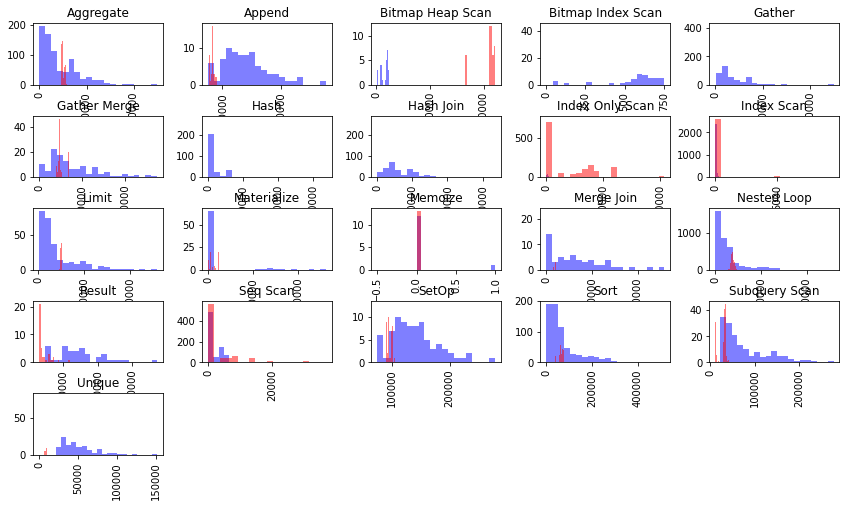

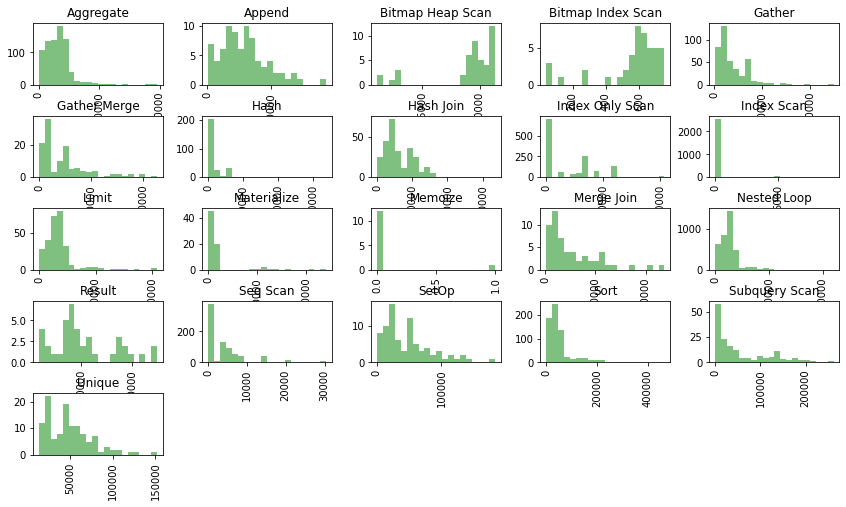

In [10]:
plotdf = final_df.copy()
logplot = False

ax = plotdf.hist(column="Actual Latency (us)", by="Node Type", figsize=(14,8), log=logplot, bins=20, alpha=0.5, color="b")
plot_ax = ax.ravel()[:final_df["Node Type"].nunique()]
ax = plotdf.hist(ax=plot_ax, column="Estimated Latency (us)", by="Node Type", figsize=(14,8), log=logplot, bins=20, alpha=0.5, color="r")
plt.show()

ax = plotdf.hist(column="diff (us)", by="Node Type", figsize=(14,8), log=logplot, bins=20, alpha=0.5, color="g")
plt.show()

In [11]:
metrics_df = final_df.copy()
display(metrics_df["diff (us)"].describe())

diff_df_data = []
for node_type, gdf in metrics_df.groupby("Node Type"):
    median_diff = np.percentile(gdf["diff (us)"], 50)
    diff_df_data.append((node_type, median_diff))
diff_df = pd.DataFrame(diff_df_data, columns=["Node Type", "Median Diff (us)"])
display(diff_df)

count     12104.000000
mean      32644.472722
std       42965.376272
min           0.000000
25%          26.000001
50%       18177.080603
75%       51272.811109
max      497375.000000
Name: diff (us), dtype: float64

,Node Type,Median Diff (us)
0,Aggregate,61201.064180
1,Append,51659.364716
2,Bitmap Heap Scan,39748.874556
3,Bitmap Index Scan,614.999980
4,Gather,52405.500412
5,Gather Merge,34989.897129
6,Hash,72.499998
7,Hash Join,24621.999741
8,Index Only Scan,1677.805901
9,Index Scan,2.000000


In [12]:
metrics_df = final_df.copy()
print("MAE: ", metrics_df["diff (us)"].mean())

mae_data = []
for node_type, gdf in metrics_df.groupby("Node Type"):
    mae_data.append((node_type, gdf["diff (us)"].mean()))
mae_df = pd.DataFrame(mae_data, columns=["Node Type", "MAE (us)"])
display(mae_df)

MAE:  32644.4727215033


,Node Type,MAE (us)
0,Aggregate,61386.898575
1,Append,57971.237605
2,Bitmap Heap Scan,38984.410268
3,Bitmap Index Scan,562.181819
4,Gather,76658.285126
5,Gather Merge,47787.355872
6,Hash,1575.394942
7,Hash Join,31186.449361
8,Index Only Scan,7776.213745
9,Index Scan,189.196869


In [13]:
metrics_df = final_df.copy()
metrics_df["q_err"] = np.nan_to_num(
    np.maximum(
        metrics_df["Estimated Latency (us)"] / metrics_df["Actual Latency (us)"],
        metrics_df["Actual Latency (us)"] / metrics_df["Estimated Latency (us)"]
    ), nan=np.inf)
display(metrics_df["q_err"].describe())

q_df_data = []
for node_type, gdf in metrics_df.groupby("Node Type"):
    median_q = np.percentile(gdf["q_err"], 50)
    q_df_data.append((node_type, median_q))
q_df = pd.DataFrame(q_df_data, columns=["Node Type", "Median Q"])
display(q_df)

count     1.210400e+04
mean               inf
std                NaN
min       1.000011e+00
25%       2.364800e+00
50%       3.094420e+01
75%      1.797693e+308
max                inf
Name: q_err, dtype: float64

/home/wanshenl/.venvs/default/lib/python3.10/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,Node Type,Median Q
0,Aggregate,2.137141e+00
1,Append,1.646083e+00
2,Bitmap Heap Scan,1.739247e+01
3,Bitmap Index Scan,1.797693e+308
4,Gather,1.797693e+308
5,Gather Merge,1.750584e+00
6,Hash,1.797693e+308
7,Hash Join,1.797693e+308
8,Index Only Scan,1.797693e+308
9,Index Scan,1.797693e+308


In [14]:
metrics_df = final_df.copy()
display(metrics_df["Estimated Latency (us)"].describe())
display(metrics_df["Actual Latency (us)"].describe())

count     12104.000000
mean      39555.322672
std       39118.509349
min           0.000000
25%           0.000000
50%       30450.498852
75%       75237.510431
max      127029.170656
Name: Estimated Latency (us), dtype: float64

count     12104.000000
mean      36907.215333
std       60310.320868
min           0.000000
25%           7.000000
50%       10791.999817
75%       49254.500389
max      517341.003418
Name: Actual Latency (us), dtype: float64